<a href="https://colab.research.google.com/github/TheClassicTechno/audioclassmodel/blob/main/RALCT_Audio_Model_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Welcome to my project!
Randomized Audiomentational Layered Convolutional Transformers (RALCT): 
A Novel Deep Learning Model for Environmental Sound Recognition

RALCT's consistent classification accuracy: 93-95% <br>
best validation accuracy so far: l_accuracy: 95.53% with learning rate 1e-3 and batch size 32 need capture graphs next time <br>
human accuracy: (81.3%) 

Techniques: MFCCS+spectrogram layers, random augmentations, combine transformer and cnn models together





# CODE OF THIS RESEARCH PROJECT STARTS BELOW! :)

#Import Dataset, Files, Libraries 

In [1]:
! pip install kaggle
!mkdir ~/.kaggle
#!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download chrisfilo/urbansound8k  
#! kaggle datasets download chrisfilo/urbansound8k  --force


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
100% 5.59G/5.61G [00:39<00:00, 227MB/s]
100% 5.61G/5.61G [00:39<00:00, 154MB/s]


In [2]:

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download chrisfilo/urbansound8k
! unzip urbansound8k

Streaming output truncated to the last 5000 lines.
  inflating: fold4/151877-5-1-0.wav  
  inflating: fold4/154758-5-0-0.wav  
  inflating: fold4/154758-5-0-1.wav  
  inflating: fold4/154758-5-0-10.wav  
  inflating: fold4/154758-5-0-11.wav  
  inflating: fold4/154758-5-0-12.wav  
  inflating: fold4/154758-5-0-13.wav  
  inflating: fold4/154758-5-0-14.wav  
  inflating: fold4/154758-5-0-15.wav  
  inflating: fold4/154758-5-0-16.wav  
  inflating: fold4/154758-5-0-17.wav  
  inflating: fold4/154758-5-0-18.wav  
  inflating: fold4/154758-5-0-19.wav  
  inflating: fold4/154758-5-0-2.wav  
  inflating: fold4/154758-5-0-20.wav  
  inflating: fold4/154758-5-0-21.wav  
  inflating: fold4/154758-5-0-3.wav  
  inflating: fold4/154758-5-0-4.wav  
  inflating: fold4/154758-5-0-5.wav  
  inflating: fold4/154758-5-0-6.wav  
  inflating: fold4/154758-5-0-7.wav  
  inflating: fold4/154758-5-0-8.wav  
  inflating: fold4/154758-5-0-9.wav  
  inflating: fold4/155320-3-0-0.wav  
  inflating: fold4/156362

In [3]:
import torch
from scipy.io.wavfile import write
from IPython.display import Audio
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tqdm import tqdm 
import IPython.display as ipd
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

#Data Preprocessing 

### The Dataset: Audio Augmentations Method

In [4]:

seconds=5

WINDOW_SIZE=2048 #portion u look at when transforming audio, a power of 2 as value
HOP_SIZE=441 #10 milisec jump in time, default hop length is 512 #quarter hop, overlap four dif windows
SAMPLING_FREQUENCY=44_100
SAMPLE_LENGTH=seconds*SAMPLING_FREQUENCY #most files are 4 secs long

N_MELS=128
NOISE_CHANCE=0
PITCH_CHANCE=0
SPEED_CHANCE =0
NOISE_FACTOR=0.001
WINDOW_SIZE=2048 #portion u look at when transforming audio, a power of 2 as value
HOP_SIZE=441 #10 milisec jump in time, default hop length is 512 #quarter hop, overlap four dif windows


#NOISE_FACTOR=np.random.rand(1)*0.05

def audiomentations(audio, noise_chance, pitch_chance, speed_chance, noise_factor, sample_rate):
    if np.random.rand(1)<noise_chance:
      noise_scale=np.random.rand(1)*noise_factor
      audio = (audio +noise_scale* np.random.normal(size=audio.shape[0]))
    #ideally audio starts at numpy, every operation in audiomentations is numpy operation (librosa built on numpy)

    
    if np.random.rand(1)<pitch_chance:
      #n_steps=0
      n_steps=np.random.randint(-5,6)
      audio = (librosa.effects.pitch_shift(audio, sample_rate, n_steps))
    
      
    if np.random.rand(1)<speed_chance:
      #speed_rate=1 # 1 to 1.5
      #speed_rate=(np.random.randint(-2,6)/10)+1 #0.8 to 1.5
      speed_rate=(np.random.randint(0,6)/10)+1 #1 to 1.5
      audio = (librosa.effects.time_stretch(audio, speed_rate))
    

    return audio
    #augmentation only on training set, not validation 
   




In [5]:


CSV_FILE="UrbanSound8K.csv" 
data = pd.read_csv(CSV_FILE)
data.head(20)

print(list(data['classID'].unique()))
ids = []
temp=list(data['class'].unique())
for name in temp:
  ids.append(list(data[data['class']==name]['classID'].unique()))
  
print((ids))


[3, 2, 1, 0, 9, 6, 8, 5, 7, 4]
[[3], [2], [1], [0], [9], [6], [8], [5], [7], [4]]


In [6]:
data_list=data["class"].unique().tolist()
class_name_dict={}
name_to_id={}
for name in data_list:
  #print(name)
  '''
  class_num=data[data["class"]==name]["classID"].iloc[0]
  class_name_dict[class_num]=name
  '''
for name in data_list:
  class_num=data[data["class"]==name]["classID"].iloc[0]
  class_name_dict[class_num]=name
  name_to_id[name]=class_num


print(name_to_id)






{'dog_bark': 3, 'children_playing': 2, 'car_horn': 1, 'air_conditioner': 0, 'street_music': 9, 'gun_shot': 6, 'siren': 8, 'engine_idling': 5, 'jackhammer': 7, 'drilling': 4}


In [7]:
if CSV_FILE=="UrbanSound8K.csv":

  print(data['class'].value_counts())
else:
  #data['class']=data['category']
  data=data.rename(columns={"category": "class"})
  print(data['class'].value_counts())


dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


##data cleaning
###removing files from dataset that include only static noise, or has multiple classes of sounds in file 
ex: 13577-3-0-2.wav (drilling and dog bark inside)

###bad files
relabel
- 132016-9-0-16.wav (predicted=jackhammer, actual=streetmusic) num=10
- 180937-7-3-33.wav(dril, jackhammer) num=24


this one remove bc two classes:
- 13577-3-0-2.wav(dril bark) 32
- 43802-1-2-0.wav(siren, car horn) 27
- 180937-4-2-1.wav (predicted=jackhammer, actuak=drilling) num= 3
= 164797-2-0-47.wav (predicted=air dontiiona, actual =children( num=4
- 35548-9-0-23.wav (children, street) num=6
- 180937-4-1-30.wav(jackhammer drilling) num=18

remove bc no classes:
- 74677-0-0-0.wav(drilling air conditioner) num=23
- 51022-3-30-4.wav (predicted=air conditioner, actual=dog bark)num=5
- 177592-5-0-2.wav (air conditioner, engine idling)num=12

In [8]:
filestobedeleted= ["7965-3-22-0.wav","186336-9-0-4.wav","177592-5-0-2.wav","59037-2-1-2.wav", "13577-3-0-2.wav","43802-1-2-0.wav","180937-4-2-1.wav","35548-9-0-23.wav","180937-4-1-30.wav","74677-0-0-0.wav","51022-3-30-4.wav","177592-5-0-2.wav"]
data=data[~data["slice_file_name"].isin(filestobedeleted)]
print(data['class'].value_counts())



jackhammer          1000
children_playing     999
air_conditioner      999
engine_idling        999
street_music         998
drilling             998
dog_bark             997
siren                929
car_horn             428
gun_shot             374
Name: class, dtype: int64


In [9]:
filestoberelabeled= {"13577-3-0-2.wav":'drilling',"4918-3-0-0.wav":'dog_bark',"132016-9-0-16.wav":'street_music',"180937-7-3-33.wav":'jackhammer'}

for key, value in filestoberelabeled.items():
  data.loc[data['slice_file_name']==key,'class']=value
  data.loc[data['slice_file_name']==key,'classID']=name_to_id[value]

print(data['class'].value_counts())

#dont run this if havent figured out what files to delete yet


jackhammer          1000
children_playing     999
air_conditioner      999
engine_idling        999
street_music         998
drilling             998
dog_bark             997
siren                929
car_horn             428
gun_shot             374
Name: class, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [10]:
  



def features_extract(file_name): #load in files as non augmented, augment later
  

    #audio_binary = tf.io.read_file(file_path)
    #audio, sample_rate = tf.audio.decode_wav(tf.io.read_file(file_name), desired_samples = SAMPLE_LENGTH)
    audio, sample_rate = librosa.load(file_name, sr=SAMPLING_FREQUENCY, res_type = 'kaiser_fast') #take in file name and load file, output audio sample rate
    audio=audiomentations(audio, NOISE_CHANCE, PITCH_CHANCE, SPEED_CHANCE, NOISE_FACTOR, sample_rate)
    '''
    if (sample_rate!=SAMPLING_FREQUENCY):
      audio = librosa.resample(audio, librosa.core.get_samplerate(file_name), SAMPLING_FREQUENCY)
    '''
    #assert(sample_rate==SAMPLING_FREQUENCY), "sampling freq isnt 44,100 for this loaded file" #throws error
    #def {audio, sample_rate} #dictionary
    #audio=audio[SAMPLE_LENGTH:numOfZeros]

    #random augmentations, mixtures of augmentions
    
    #if (CSV_FILE="esc50.csv") SAMPLE_LENGTH=220500
    if audio.shape[0]==SAMPLE_LENGTH:
        pass
    elif audio.shape[0]>SAMPLE_LENGTH:
        audio=audio[0:SAMPLE_LENGTH]
    elif audio.shape[0]<SAMPLE_LENGTH: #repeat the audio from beginning if less than 4 sec
        audio = np.resize(audio,SAMPLE_LENGTH)
    #audio_tf=tf.convert_to_tensor(audio, dtype=tf.float32)

    #padding audio with zeroes make sure audio length is the same
    '''
    if audio.shape[0]==SAMPLE_LENGTH:
        pass
    elif audio.shape[0]>SAMPLE_LENGTH:
        audio=audio[0:SAMPLE_LENGTH]
    elif audio.shape[0]<SAMPLE_LENGTH:
        numOfZeros=SAMPLE_LENGTH-audio.shape[0]
        zerosArray=np.zeros(numOfZeros)
        audio=np.concatenate((audio, zerosArray), axis=0)
    audio_tf=tf.convert_to_tensor(audio, dtype=tf.float32)
    #change audiio into mfccs
    '''
    ''' 
    mfccs_features = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 100, hop_length=HOP_SIZE, n_fft=WINDOW_SIZE) #sound=wave like sin curves
    mfccs_scaled_features = np.mean(mfccs_features.T,axis = 0)
    
    '''
    #spectrograms+mfccs= more complex concatenate these
    #librosa.feature.melspectrogram(y=audio, sr=sample_rate, )

    
 
   
    #melspectrogram includes fourier transforms, doing the math for you
    '''
    spectr= librosa.feature.melspectrogram(audio, sr=sample_rate, n_fft = WINDOW_SIZE, hop_length = HOP_SIZE, center = True, n_mels = N_MELS, fmax=None)
    spectr_db = librosa.power_to_db(spectr, ref = np.max)
    concat=np.concatenate((spectr_db, mfccs_features), axis=0 )
    concat=np.expand_dims(concat, axis=-1)
    #axis=-1 the last axis, place new dimention in last spot
    #np normalize? concatenate in this function? for cnn training but skip normalize for now
    return concat
    
    '''
    return audio
    #, sample_rate
 
#   shape of these things like spectr_db


##Processing the Dataset using a convenient method

In [11]:
audio_dataset_path = '' #empty because we are already at fold 1, fold 2, etc
extracted_features = [] #empty because its a list that we are appending to
if (CSV_FILE=="esc50.csv"): #esc50
  for index_num,row in tqdm(data.iterrows()):
      file_name = os.path.join(os.path.abspath(audio_dataset_path),'audio','audio','44100',str(row["filename"]))
      final_class_labels = row["class"]
      
      #srtest=librosa.core.get_samplerate(file_name)
      
      wav = features_extract(file_name) #data_ is a tuple
      #, sr
      #epoch level augmentations better. meansthere are augs applied when running model , every epoch will have a slightly dif representation, transformed version of the audio, dep on probability of aug appearing
      #no aug, model will start memorizing the same set of audio it sees so many times. 
      #make model generalze betterand learn, if aug at loading level, just change original file to be slightly changed , but still give 3740 files to model 50 times (epoch=50 for ex)
      extracted_features.append([wav, final_class_labels])
else: #urbansound8k 
  for index_num,row in tqdm(data.iterrows()):
      file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
      final_class_labels = row["class"]
       
      fold_nums = row["fold"]
      wav = features_extract(file_name) #data_ is a tuple
      #, sr
      #epoch level augmentations better. meansthere are augs applied when running model , every epoch will have a slightly dif representation, transformed version of the audio, dep on probability of aug appearing
      #no aug, model will start memorizing the same set of audio it sees so many times. 
      #make model generalze betterand learn, if aug at loading level, just change original file to be slightly changed , but still give 3740 files to model 50 times (epoch=50 for ex)
      extracted_features.append([wav, final_class_labels, fold_nums])

8721it [01:32, 94.66it/s] 


##SPLIT DATASET INTO AUDIO FILES AND CATEGORIES & ONE HOT ENCODING 

In [12]:
features_df=pd.DataFrame(extracted_features,columns=['audio', 'class', 'fold_num']) #'sr',
features_df.head()
features_df['audio'] 

0       [-0.004547119, -0.004837036, -0.0046081543, -0...
1       [0.0035705566, 0.0037078857, 0.0034484863, 0.0...
2       [-0.0037384033, -0.0033111572, -0.0027160645, ...
3       [0.0002593994, 1.5258789e-05, -0.00021362305, ...
4       [0.0016326904, 0.0025787354, 0.004135132, 0.00...
                              ...                        
8716    [-0.00038146973, -0.0015716553, -0.0029296875,...
8717    [0.0025024414, 0.0025939941, 0.0026550293, 0.0...
8718    [-0.01838684, -0.018035889, -0.018005371, -0.0...
8719    [0.0013885498, -0.0005645752, -0.0039978027, -...
8720    [0.017227173, 0.021865845, 0.02444458, 0.02433...
Name: audio, Length: 8721, dtype: object

In [13]:
grouped=features_df.groupby(by=["fold_num",'class'])


for idx in range(1,11):
  print("fold idx")
  print( features_df[features_df["fold_num"]==idx]['class'].value_counts())

fold idx
jackhammer          120
children_playing    100
street_music        100
air_conditioner     100
drilling            100
dog_bark             99
engine_idling        96
siren                86
car_horn             36
gun_shot             35
Name: class, dtype: int64
fold idx
jackhammer          120
dog_bark            100
drilling            100
children_playing    100
air_conditioner     100
street_music        100
engine_idling        99
siren                91
car_horn             42
gun_shot             35
Name: class, dtype: int64
fold idx
jackhammer          120
siren               119
engine_idling       107
dog_bark            100
drilling            100
children_playing    100
air_conditioner     100
street_music         99
car_horn             43
gun_shot             36
Name: class, dtype: int64
fold idx
siren               166
jackhammer          120
engine_idling       107
dog_bark            100
street_music        100
drilling            100
children_playing    10

In [14]:
X = features_df['audio']
y_text = features_df['class']

In [15]:
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y_text))

#features_df['class_encode']=[r for r in y]
#print(features_df.head)
'''
#Label Encoding  one hot encoding
#using label encoder to get back the class name using inverse label encoder 
labelencoder = LabelEncoder()
y = to_categorical(labelencoder.fit_transform(y_text)) # tranform class label. fit transform can only get a list 
#.fittransform(y) was saved to y before. change list of 3740 words into one hot encoded array (3740,10) 
#saved back 9into y, now give array of 3740,10. thats why change into y_text
#y=tf.convert_to_tensor(y)
'''

'\n#Label Encoding  one hot encoding\n#using label encoder to get back the class name using inverse label encoder \nlabelencoder = LabelEncoder()\ny = to_categorical(labelencoder.fit_transform(y_text)) # tranform class label. fit transform can only get a list \n#.fittransform(y) was saved to y before. change list of 3740 words into one hot encoded array (3740,10) \n#saved back 9into y, now give array of 3740,10. thats why change into y_text\n#y=tf.convert_to_tensor(y)\n'

## SPLIT DATASET INTO X AND y 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

In [17]:
#FOLD_NUM=1 #ONLY CHANGE THIS ONE IN K CROSS VALIDATION

#X_test=features_df[features_df["fold_num"]==FOLD_NUM]['audio']
##X_train=features_df[features_df["fold_num"]!=FOLD_NUM]['audio']

##y_train=features_df[features_df["fold_num"]!=FOLD_NUM]['class_encode'].to_numpy()
#y_test=features_df[features_df["fold_num"]==FOLD_NUM]['class_encode'].to_numpy()


In [18]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()


#this step converts dataframes to numpy

In [19]:
type (X_train)


numpy.ndarray

In [20]:
X_train = tf.stack( [aud for aud in X_train] )
#print(type(X_train_tf))
#print(X_train_tf[0])
#X_train_tf.shape

X_test= tf.stack( [aud for aud in X_test] )

## RALCT MODEL ARCHITECTURE and AUDIOMENTATIONS CLASS (rerun from here if model.fit not working)

In [21]:
#labels = y.shape[1] # total target variable or class variable
#input_size = X.shape[1] # total feature value like here n_mfcc value 
#print(f"number of total class label '{labels}'")
#print(f"number of features used '{input_size}' ")

#POSITIONAL ENCODING CLASS & LOG MEL SPECTROGRAM CLASS 

In [22]:

#customized training loop?
#frequency, time masking, tensorflow version

seconds=5

SAMPLING_FREQUENCY=44_100
WINDOW_SIZE=2048 #portion u look at when transforming audio, a power of 2 as value
HOP_SIZE=441 #10 milisec jump in time, default hop length is 512 #quarter hop, overlap four dif windows
SAMPLE_LENGTH=seconds*SAMPLING_FREQUENCY #most files are 4 secs long
WINDOW_SIZE=2048 #portion u look at when transforming audio, a power of 2 as value
HOP_SIZE=441 #10 milisec jump in time, default hop length is 512
#quarter hop, overlap four dif windows


N_MELS=128


      
      
class PositionalEncoding(tf.keras.layers.Layer):
   def __init__(self, first_shape=55, sec_shape=4, third_shape=32, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs) 
        
        self.pe = tf.Variable(initial_value = tf.random.normal(shape=(first_shape, sec_shape, third_shape), mean=0.0, stddev=0.2),
                              trainable = True, name = 'Positional_Encoding_weights') 
   def call(self, sequence):
        
        return tf.math.add(sequence, self.pe) #track gradients, back propagation, assign correct weights, train weights properly

class LogMelSpectrogram(tf.keras.layers.Layer):
    """Compute log-magnitude mel-scaled spectrograms."""

    def __init__(self, sample_rate, fft_size, hop_size, n_mels,
                 f_min=0.0, f_max=None, **kwargs):
        super(LogMelSpectrogram, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_size = hop_size
        self.n_mels = n_mels
        self.f_min = f_min
        self.f_max = f_max if f_max else sample_rate / 2
        self.mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.n_mels,
            num_spectrogram_bins=fft_size // 2 + 1,
            sample_rate=self.sample_rate,
            lower_edge_hertz=self.f_min,
            upper_edge_hertz=self.f_max)

    def build(self, input_shape):
        self.non_trainable_weights.append(self.mel_filterbank)
        super(LogMelSpectrogram, self).build(input_shape)

    def call(self, waveforms):
        """Forward pass.
        Parameters
        ----------
        waveforms : tf.Tensor, shape = (None, n_samples)
            A Batch of mono waveforms.
        Returns
        -------
        log_mel_spectrograms : (tf.Tensor), shape = (None, time, freq, ch)
            The corresponding batch of log-mel-spectrograms
        """
        def _tf_log10(x):
            numerator = tf.math.log(x)
            denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
            return numerator / denominator

        def power_to_db(magnitude, amin=1e-16, top_db=80.0):
            """
            https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
            """
            ref_value = tf.reduce_max(magnitude)
            log_spec = 10.0 * _tf_log10(tf.maximum(amin, magnitude))
            log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref_value))
            log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

            return log_spec

        spectrograms = tf.signal.stft(waveforms,
                                      frame_length=self.fft_size,
                                      frame_step=self.hop_size,
                                      pad_end=False)

        magnitude_spectrograms = tf.abs(spectrograms)

        mel_spectrograms = tf.matmul(tf.square(magnitude_spectrograms),
                                     self.mel_filterbank)

        log_mel_spectrograms = power_to_db(mel_spectrograms)

        # add channel dimension
        log_mel_spectrograms = tf.expand_dims(log_mel_spectrograms, 3)

        return log_mel_spectrograms

    def get_config(self):
        config = {
            'fft_size': self.fft_size,
            'hop_size': self.hop_size,
            'n_mels': self.n_mels,
            'sample_rate': self.sample_rate,
            'f_min': self.f_min,
            'f_max': self.f_max,
        }
        config.update(super(LogMelSpectrogram, self).get_config())

        return config

## Transformers +CNN  Model for Audio

encoding + decoding = input and output language or audio or music 

only encoding- input audio/language and output a classification

autoencoder squish into lower dimensions- tasked with recreate exact image from lower dimensional space





TRANSFORMER ENCODER CLASS 

In [23]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    #DID CONVOLUTIONS THEN ATTENTION TO DECREASE TIME STEP INFORMATION INTO A LOWER NUMBER SO ATTENTION LAYER CAN DEAL WITH SMALLER NUMBERS AND NOT GET OUT OF MEMORY
    #ATTENTION COMBINES FEATURES OF DIF TIME STEPS TOGETHER. 
    x = layers.LayerNormalization(epsilon=1e-6)(inputs) #dif from batch normalization, normalize at every single computation (normalize x - xmean all divided by x standard deviation + epsilon to avoid divide by 0)
    x = layers.MultiHeadAttention( #dot product with itself produce numbers, get important numbers, split up into dif heads, each head attends to a dif important part of your data
        key_dim=head_size, num_heads=num_heads, dropout=dropout #size of each head, how many heads/filters/dif ways to attend to pr undestand or describe your data.  head size= kernel size, how many dimensions n your multi head attention, feature size
        #Conv2D(32, 5x5 kernals) 
    )(x, x) #needs this bc this is self attention attend to itself, understand itself
    x = layers.Dropout(dropout)(x)
    res = x + inputs #residual connection, combined with other features, lose some info alow he way. the residual connection allow model to decide if previous features are  more less or equal important to features it has created
    #multihead attention on the inputs, got new representation of the inputs, residual connection allow original input to come back and be important still, add their values together
    #residuals shortcut stuff, can access info u used to know, model will figure out the most improtant parts

    # Feed Forward Part, activation part after do feature maps part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    #Dense(128, activation='relu')(y) 
    x = layers.Dense(ff_dim, activation='relu')(x) #num units in dense layer is ff_dim
    #x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(units=inputs.shape[-1])(x) #throw dimensions back into what we had before - can do residual layer again
    #x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res #encoders stacked on top of each other

# MODEL AUG CLASS
##GRADIENT TAPE INSIDE THE CLASS 



In [24]:
class ModelAug (keras.Model): #has all features and methods of keras models= parameter is still input and output
    def train_step(self, data): #training loop can have augmentations 
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data #unaugmented data
        #print(type(x))
        x=x.numpy()
        #print(type(x))

        if (x.shape[0]!=None) :
          list_of_aug_audios=[] #python list of numpy arrays
          for i in range(x.shape[0]):
            audio=x[i]
            #audio=audiomentations(audio, NOISE_CHANCE, PITCH_CHANCE, SPEED_CHANCE, NOISE_FACTOR, SAMPLING_FREQUENCY)
            if audio.shape[0]==SAMPLE_LENGTH:
              pass
            elif audio.shape[0]>SAMPLE_LENGTH:
              audio=audio[0:SAMPLE_LENGTH]
            elif audio.shape[0]<SAMPLE_LENGTH: #repeat the audio from beginning if less than 4 sec
              audio = np.resize(audio,SAMPLE_LENGTH)
            #ensure all audio files have same length
            list_of_aug_audios.append(audio)
          x=np.stack(list_of_aug_audios, axis=0) #x is a 2d array (row dim=examples, y is indep number (44100*4))

        #tf.convert_to_tensor()
        with tf.GradientTape() as tape: #a gradient tape records all tensorflow operations , call the model, x gets transformed into spec/mfccs/concatenate, etc etc etc
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            #backpropgation used to figure out how weights should be changed - optimize the model's weights , main method to train a network
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics} # in this batch, step of training, got this much loss and accuracy 

# BUILDING THE RALCT MODEL & DETAILS OF ITS LAYERS 

In [25]:


def build_model(
    n_classes,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks, #transformer encoders happen in a row num of blocks t9mes stack that many tras=nsformer blocks on top of each otehr
    mlp_units, #do dense layers after [128,128,64] all dense layers
    dropout=0,
    mlp_dropout=0,  sample_rate=SAMPLING_FREQUENCY, duration=seconds,
              fft_size=WINDOW_SIZE, hop_size= HOP_SIZE, n_mels=N_MELS
):

    n_samples = sample_rate * duration
    # Accept raw audio data as input
    inputs = Input(shape=(n_samples,), name='input', dtype='float32')

    



    # Process into log-mel-spectrograms. (This is your custom layer!)
    spectro = LogMelSpectrogram(sample_rate, fft_size, hop_size, n_mels)(inputs) 
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(spectro)
    #0 is batch size, 1 is time, 2 is features(mel bins, what freq are in that section of time), stack for each time, stack mfccs
  
      
      
    # Normalize data (on frequency axis)
    spectro_norm = BatchNormalization(axis=2)(spectro)
    
    mfccs_norm = BatchNormalization(axis=2)(mfccs)
    #normalize spec and mfcc separately because they have dif numbers and units inherently
    #batch norm means normalize between 0 to 1 
    x = tf.concat([spectro_norm, mfccs_norm], axis=3, name='concat') #concatenate along/extends the feature dimention. add more features 
    # in that case, both the batch size and the time must be the same for both the spectros and mfccs
    #axis 2 vs axis 3. axis 2 tells concat to align matrice array to feature dimension. first dim= time step. 2nd=features
    #  3rd dimention is dif represent of features. red green blue dif info but represen same type
    #benefit : 3rd axis = stack on the channel axis. the filter kernel can treat the mfcss and spect #s different
    #
    '''
    xbranch1 = Conv2D(16, (3, 3), activation='relu', padding = 'same')(x) #16 is number of filters, channels/feature maps produced, 16 dif way describe audio
    xbranch1 = BatchNormalization()(xbranch1)

    xbranch2 = Conv2D(16, (5, 5), activation='relu', padding = 'same')(x) #(3,1) was because x and y have dif meanings for audio, same meanings for image. spectrogram- x dir means time, y dir is the features. 
    xbranch2 = BatchNormalization()(xbranch2)

    xbranch3 = Conv2D(16, (7, 7), activation='relu', padding = 'same')(x)
    xbranch3 = BatchNormalization()(xbranch3)

    xbranch4 = Conv2D(16, (11, 11), activation='relu', padding = 'same')(x)
    xbranch4 = BatchNormalization()(xbranch4)
    '''

    #concatenate as inception block 
    #x = tf.concat([xbranch1, xbranch2, xbranch3, xbranch4], axis=3, name='incep_concat') #sep concat so model can choose what kernel to do, 3x3 or 5x5 etc
    #400x128 #+ add tog = destroying info #axis 0 batch 1 time 2 feature(in the spectrogram, or a freq in a time) 3 channel (mel and spec same dimension)
    #gives model opportunity to say the other kernels are important, not constrict model to a specific filter like 5x5
    #higher weight=more important



    
    x = Conv2D(32, (5, 5), activation='relu', padding = 'same')(x) #16 is number of filters, channels/feature maps produced, 16 dif way describe audio
    x = BatchNormalization()(x)
    x = MaxPool2D((1, 3))(x) #y.shape 2 grab entire length of the features, take max of entire feature space. throw away all other features. lose features. dont want to do y.shape(2) in the max pool
    #convolutions 2 channels deep, 3 by 3, thats becasue we have mfccs and spec
    x = Dropout(0.1)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding = 'same')(x) #(3,1) was because x and y have dif meanings for audio, same meanings for image. spectrogram- x dir means time, y dir is the features. 
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(3, 3))(x)
    x = Dropout(0.1)(x)
    
    x = Conv2D(32, (3, 3), activation='relu', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size=(3, 3))(x)
    x = Dropout(0.1)(x)
    
   
   

    first_shape=55 #if (CSV_FILE=="esc50.csv") else 44
      
    
     
    
    x = PositionalEncoding()(x)
   
    #add location






   
    #inputs = keras.Input(shape=input_shape)
    #x = inputs
    # n_samples = sample_rate * duration
    # Accept raw audio data as input
  
    #inputs_aug=Audiomentations(NOISE_CHANCE, PITCH_CHANCE, SPEED_CHANCE, SAMPLING_FREQUENCY)(inputs)



    
    
    
    
    
    # Process into log-mel-spectrograms

    #0 is batch size, 1 is time, 2 is features(mel bins, what freq are in that section of time), stack for each time, stack mfccs
  
    #decrease time steps or else memory too big when multiplying together
    #average time not features, shrink time dimension by factor of 5 not feature dimensions tho
    # Normalize data (on frequency axis)

    #normalize spec and mfcc separately because they have dif numbers and units inherently
    #batch norm means normalize between 0 to 1 
    #axis  1 time, 2 features


  



    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    #x = layers.GlobalAveragePooling2D(data_format="channels_first")(x) #flattening or averaging values, stride along 1 dimension, averages along time or features , treat all features same 1D. only have a 2D input- time step and feature, no channels
    #globalpool lose too much data
    x = Flatten()(x) 
    for dim in mlp_units: #first hidden layer has first dims, 100 in second hidden layer, for example, etc
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_classes, activation="softmax")(x) #rip off last layer and take a pretrained model on urbansound8k and tarain on esc50.
    return ModelAug(inputs, outputs) #very first and last values- inputs and outputs

In [26]:
#X_test_tf.shape

# RUNNING AND TRAINING THE MODEL
### REMEMBER
UrbanSound8K n_classes=10! urbansound8K contains 44100 and 22050 hz audio files




In [27]:
#input_shape = x_train.shape[1:]

model = build_model(
    #n_classes=50,
    n_classes=10,
    head_size=64, #before was 32
    num_heads=4,
    ff_dim=32,
    num_transformer_blocks=2,
    mlp_units=[64], #before was 128
    mlp_dropout=0.1, #before was 0.4
    dropout=0.25,
)





In [28]:
EPOCHS=120
BATCH_SIZE=32
total_train = X_train.shape[0]
STEPS=(total_train/BATCH_SIZE)*EPOCHS
initial_learning_rate=1e-3 #was 1e-3 then 1e-4 before
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate, STEPS)


model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=lr_decayed_fn),
    metrics=['accuracy'],  run_eagerly=True
)
model.summary()

Model: "model_aug"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 220500)]     0           []                               
                                                                                                  
 log_mel_spectrogram (LogMelSpe  (None, 496, 128, 1)  0          ['input[0][0]']                  
 ctrogram)                                                                                        
                                                                                                  
 tf.signal.mfccs_from_log_mel_s  (None, 496, 128, 1)  0          ['log_mel_spectrogram[0][0]']    
 pectrograms (TFOpLambda)                                                                         
                                                                                          

In [29]:
#X_test=X_test.to_numpy()
#type(X_test)

#Train Model (try rerun from the model definition)

In [30]:
#callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    X_train,
    #X_train,
    y_train,
    
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #callbacks=callbacks,
    validation_data = (X_test, y_test), verbose = 1)
    #validation_data = (X_test, y_test), verbose = 1)
  
#validation_split=0.2,

#model.evaluate(X_test_tf, y_test, verbose=1)

Epoch 1/120
218/218 [==============================] - 67s 229ms/step - loss: 1.9591 - accuracy: 0.3420 - val_loss: 2.1896 - val_accuracy: 0.3117
Epoch 2/120
218/218 [==============================] - 48s 222ms/step - loss: 1.3337 - accuracy: 0.5420 - val_loss: 1.6547 - val_accuracy: 0.4923
Epoch 3/120
218/218 [==============================] - 48s 222ms/step - loss: 1.0021 - accuracy: 0.6583 - val_loss: 0.9457 - val_accuracy: 0.7020
Epoch 4/120
218/218 [==============================] - 48s 220ms/step - loss: 0.7959 - accuracy: 0.7371 - val_loss: 0.6743 - val_accuracy: 0.7840
Epoch 5/120
218/218 [==============================] - 48s 220ms/step - loss: 0.6805 - accuracy: 0.7671 - val_loss: 0.9283 - val_accuracy: 0.7163
Epoch 6/120
218/218 [==============================] - 48s 218ms/step - loss: 0.5903 - accuracy: 0.7999 - val_loss: 0.5577 - val_accuracy: 0.8361
Epoch 7/120
218/218 [==============================] - 48s 219ms/step - loss: 0.5526 - accuracy: 0.8121 - val_loss: 0.5556 -

In [31]:
#for layer in model.layers:
  #layer.trainable=True

# SAVING MODEL TO GOOGLE DRIVE

In [32]:
#from google.colab import drive
#drive.mount('/content/drive')


In [33]:

#save to drive as h5 model tf model
model_to_be_saved="trial_model" #change this for every best accurate model run and trained
# Save the entire model as a SavedModel.
#!mkdir -p saved_model
#'/content/drive/MyDrive/Mask_RCNN'
#model.save('/content/drive/MyDrive/saved_models/'+model_to_be_saved+'.h5')


#CONVERTING MODEL TO TFLITE MODEL 

In [34]:
'''
model_to_be_converted="trial_model"
saved_model_dir='/content/drive/MyDrive/saved_models/'+ model_to_be_converted
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

# Save the tflite model.
with open('/content/drive/MyDrive/saved_models/tfliteexports/'+ model_to_be_converted+'.tflite', 'wb') as f:
  f.write(tflite_model)
'''

'\nmodel_to_be_converted="trial_model"\nsaved_model_dir=\'/content/drive/MyDrive/saved_models/\'+ model_to_be_converted\n# Convert the model\nconverter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory\nconverter.target_spec.supported_ops = [\n  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.\n  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.\n]\ntflite_model = converter.convert()\n\n# Save the tflite model.\nwith open(\'/content/drive/MyDrive/saved_models/tfliteexports/\'+ model_to_be_converted+\'.tflite\', \'wb\') as f:\n  f.write(tflite_model)\n'

In [35]:
'''

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
tflite_model = converter.convert()

open("converted_model.tflite", "wb").write(tflite_model)
'''

'\n\nconverter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)\nconverter.target_spec.supported_ops = [\n  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.\n  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.\n]\ntflite_model = converter.convert()\n\nopen("converted_model.tflite", "wb").write(tflite_model)\n'

In [36]:
'''
model_to_be_loaded="trial_model"
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/saved_models/'+model_to_be_loaded)
'''
# Check its architecture
#loaded_model.summary()

'\nmodel_to_be_loaded="trial_model"\nloaded_model = tf.keras.models.load_model(\'/content/drive/MyDrive/saved_models/\'+model_to_be_loaded)\n'

In [37]:
#loaded_model=loaded_model.layers[:-1]

# PRINTING OUT LAYERS OF MODEL 

In [38]:
#ONLY RUN THIS CELL. OUR MODEL IS NOT EXACTLY SEQUENTIAL. OURS HAS RESIDUAL CONNECTIONS, CONCATENATIONS
'''
base_output=loaded_model.layers[-2].output


for layer in loaded_model.layers:
    print(layer.name)



new_output=layers.Dense(50, activation="softmax")(base_output)
esc50MODEL=tf.keras.models.Model(inputs=loaded_model.inputs, outputs=new_output)
print(esc50MODEL.summary())

'''


'''
    if layer.name=='dense_6':
    
      layer._name = layer.name + str("_7")
      break

'''


'\n    if layer.name==\'dense_6\':\n    \n      layer._name = layer.name + str("_7")\n      break\n\n'

In [39]:
#first_layer=loaded_model.layers[0]
#print(type(first_layer))

#last_layer=loaded_model.layers[-1]
#print(type(last_layer))



In [40]:
#DONT RUN THIS IN TRANSFER LEARNING
#for layer in esc50MODEL.layers[:-1]:
  #layer.trainable=False

In [41]:
#print(esc50MODEL.trainable_variables)

In [42]:
#model=esc50MODEL

## VISUALIZING RESULTS 


Text(0.5, 1.0, 'Training-Validation Accuracy')

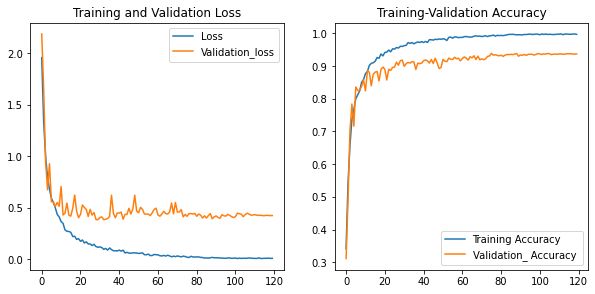

In [43]:
#saving the model history
loss = pd.DataFrame(model.history.history)

#plotting the loss and accuracy 
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.plot(loss["loss"], label ="Loss")
plt.plot(loss["val_loss"], label = "Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label = "Training Accuracy")
plt.plot(loss['val_accuracy'], label ="Validation_ Accuracy ")
plt.legend()
plt.title("Training-Validation Accuracy")

## Prediction 

In [44]:
prediction = model.predict(X_test)
print(prediction.shape)

# finding class with larget predicted probability using argmax of numpy 
y_pred = np.argmax(prediction, axis = 1)  # prediction using model 
y_test_orig = np.argmax(y_test, axis = 1) # original y_test
print(y_pred)
#argmax= look at each row and get index with highest number

(1745, 10)
[0 2 4 ... 4 5 8]


In [45]:
data.columns

Index(['slice_file_name', 'fsID', 'start', 'end', 'salience', 'fold',
       'classID', 'class'],
      dtype='object')

## PUTTING ALL CATEGORY NAMES INTO A DICTIONARY 

In [46]:
#target and category = esc50
#classID and class = urbansound8k
data_list=data["class"].unique().tolist()
class_name_dict={}
for name in data_list:
  #print(name)
  '''
  class_num=data[data["class"]==name]["classID"].iloc[0]
  class_name_dict[class_num]=name
  '''
for name in data_list:
  class_num=data[data["class"]==name]["classID"].iloc[0]
  class_name_dict[class_num]=name
  

print(class_name_dict)


{3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}


In [47]:
#Getting Class Label Name
#class_name = np.array(features_df['class'].unique().tolist())
'''
for num in range(len(class_name_dict)):
  print(class_name_dict[num])
'''


class_name=[class_name_dict[num] for num in range(len(class_name_dict)) ]
print(class_name)

          

['air_conditioner', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer', 'siren', 'street_music']


In [48]:
#CLASSIFICATION REPORT CODE ACQUIRED FROM SONU KUMARI
print(classification_report(y_test_orig, y_pred, target_names = class_name))
#support means the total number of classes in test set

                  precision    recall  f1-score   support

 air_conditioner       0.95      0.97      0.96       200
        car_horn       0.95      0.95      0.95        85
children_playing       0.86      0.86      0.86       200
        dog_bark       0.91      0.93      0.92       199
        drilling       0.95      0.95      0.95       200
   engine_idling       0.97      0.96      0.96       200
        gun_shot       0.99      0.97      0.98        75
      jackhammer       0.96      0.98      0.97       200
           siren       0.96      0.96      0.96       186
    street_music       0.91      0.86      0.88       200

        accuracy                           0.94      1745
       macro avg       0.94      0.94      0.94      1745
    weighted avg       0.94      0.94      0.94      1745



In [49]:

confusion_df = pd.DataFrame(confusion_matrix(y_test_orig, y_pred), columns = class_name, index = class_name)

print("Confusion Matrix for Audio Dataset")

confusion_df



Confusion Matrix for Audio Dataset


,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
air_conditioner,194,0,1,0,2,1,0,0,0,2
car_horn,0,81,0,0,0,0,0,1,0,3
children_playing,2,0,173,12,1,4,0,0,2,6
dog_bark,2,0,8,185,0,0,0,0,2,2
drilling,0,0,0,2,190,0,1,6,0,1
engine_idling,2,1,3,1,0,192,0,1,0,0
gun_shot,0,0,0,1,0,0,73,0,0,1
jackhammer,0,0,0,0,3,0,0,197,0,0
siren,1,1,1,1,1,1,0,0,178,2
street_music,3,2,15,1,4,0,0,0,3,172


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, stratify = y)

# CODE CELLS BELOW CHECKS EXACTLY WHICH FILES THE RALCT MODEL MISLABELED 

In [51]:
type(X_test)

pandas.core.series.Series

In [52]:
#thought air conditioner is a dog bark
#print(data[y_pred])
predicted_classes=[]
true_classes=[]
mislabeled_index=[]
mislabeled_audios=[]
#actual_index=[]

mislabeled_final_files=[]
for i in range(len(y_pred)):
#filename= esc50
# slice file name =urbansound
    if ((y_pred[i]!=y_test_orig[i])):
      predicted_classes.append(y_pred[i])
      mislabeled_index.append(i)
      #actual_index.append(X_test.index[i]) 
      mislabeled_final_files.append(data.loc[X_test.index[i]]["slice_file_name"]) #URBANSOUND
      #mislabeled_final_files.append(data.loc[X_test.index[i]]["filename"]) #ESC50
      #mislabeled_final_files.append(data_bal.loc[X_test.index[i]]["slice_file_name"])
      true_classes.append(y_test_orig[i])
      #mislabeled_audios.append( X_test_tf[i]) #maybe uncomment this
      mislabeled_audios.append( X_test[i])
      #
      '''
      mislabeled_index=(i) #this sound was mislabeled
      mislabeled_wav = X_test_tf[i]
      print(mislabeled_wav)
      '''

#actual class label, predicted class label, audio file

#just an example - true class: dog bark  predicted class: car horn find alll wav files that satisfy that, make play button for all these audio
#del mislabeled_wav


KeyError: ignored

In [ ]:
num=1 #keep changing this num
print("bad file name ",mislabeled_final_files[num])
print("predicted class ",class_name_dict[predicted_classes[num]])

print("actual class ",class_name_dict[true_classes[num]])

ipd.Audio(mislabeled_audios[num], rate=44_100)
#only delete the file if a human cant distinguish between them



bad files
relabel
 132016-9-0-16.wav (predicted=jackhammer, actual=streetmusic) num=10
180937-7-3-33.wav(dril, jackhammer) num=24
 urbansound is a less clean dataset than esc50

 this one remove bc two classes:
  13577-3-0-2.wav(dril bark) 32
 43802-1-2-0.wav(siren, car horn) 27
 180937-4-2-1.wav (predicted=jackhammer, actuak=drilling) num= 3
164797-2-0-47.wav (predicted=air dontiiona, actual =children( num=4
 35548-9-0-23.wav (children, street) num=6
 180937-4-1-30.wav(jackhammer drilling) num=18

remove bc no classes:
 74677-0-0-0.wav(drilling air conditioner) num=23
51022-3-30-4.wav (predicted=air conditioner, actual=dog bark)num=5
177592-5-0-2.wav (air conditioner, engine idling)num=12



In [ ]:
'''
for i in range(len(y_pred)):
  
  if (y_pred[i]==0 and y_test_orig[i]==2):
    print(i)
    mislabeled_index=(i) #this sound was mislabeled
    mislabeled_wav = X_test_tf[i]
    print(mislabeled_wav)
ipd.Audio(X_test_tf[414], rate=44_100)
'''

In [ ]:
#if (not (y_pred[i]==class and y_test_orig[i]==class))
'''
len(mislabeled_audios)
for i, audios in enumerate(mislabeled_audios):
  
  #print(predicted_classes[i])
ipd.Audio(mislabeled_audios[0], rate=44_100)
'''

In [ ]:
#type(X_train_tf)
#if (X_train.index==1196) #index correspond to orig x or dataset
print(X_test.index[394]) #1196 is number in x train. this staatement equals 1928 which is the index in the original X
print(data_bal.loc[568])
bad_files=[]
bad_files.append(data_bal.loc[568]["slice_file_name"])
print(bad_files)

In [ ]:
pip install tensorflowjs==2.3.0

tensorflowjs_converter \
--input_format=keras \
--output_format=tfjs_graph_model \
--split_weights_by_layer \
--weight_shard_size_bytes=99999999 \ 
--quantize_float16=* \
artifacts/model_tf_keras.h5 artifacts/model_tfjs